In [40]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [66]:
from madmom.features.tempo import TempoEstimationProcessor
from madmom.features.beats import RNNBeatProcessor
from madmom.processors import SequentialProcessor

import librosa
import librosa.display
import pandas as pd
import utility_functions as utils
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact, widgets

importlib.reload(utils)

<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/utility_functions.py'>

In [42]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

In [43]:
# Utility functions

def calculate_spectral_features(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Define the frame and hop length for STFT calculations
    FRAME_LENGTH = 2048
    HOP_LENGTH = 512

    # Calculate spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    # Calculate spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    # Calculate spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

    return spectral_centroids, spectral_rolloff, spectral_bandwidth

def calculate_tempo(audio_file):
    pipeline = SequentialProcessor([
        RNNBeatProcessor(),
        TempoEstimationProcessor(fps=100)
    ])
    
    tempo_histogram = pipeline(audio_file)
    sorted_tempo_histogram = tempo_histogram[tempo_histogram[:, 1].argsort()[::-1]]
    
    # We need the two most probable tempos because it's always the tempo and the half tempo (not necessarily in this order we will need
    # to sort it later in the dataframe.)
    top_two_tempos = sorted_tempo_histogram[:2, :]
    
    return top_two_tempos

def calculate_energy_of_frames(audio_file, frame_length=2048, hop_length=512):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Initialize an array to store energy values
    energy = np.array([
        np.sum(np.square(y[i: i + frame_length]))
        for i in range(0, len(y) - frame_length + 1, hop_length)
    ])

    return energy

def std_of_local_tempos(df):
    stds = []
    
    for index, row in df.iterrows():
        print(index)
        std = np.std(row['Local Tempos'])
        stds.append(std)
        
    df['Std Local Tempo'] = std
    return df

def convert_tempo(tempo_string):
    if isinstance(tempo_string, str):
        tempo_list_str = tempo_string.strip('[]').split()
        tempo_list = []
        
        for tempo in tempo_list_str:
            try:
                # Try converting the string to float and add to the list
                tempo_list.append(float(tempo))
            except ValueError:
                # If conversion fails, print the problematic part and skip it
                print(f"Cannot convert '{tempo}' to float.")
        return tempo_list
    return tempo_string  # Return the input if it's not a string

In [44]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/baseline_data.xlsx', engine='openpyxl')

<b>We have numerous columns in the dataframe:</b>

In [45]:
df.columns

Index(['Artist', 'Album', 'Song', 'Coast', 'Release Year', 'Tempo1', 'Tempo2',
       'Duration (s)', 'Sample Rate (Hz)', 'Path', 'Lyrics'],
      dtype='object')

<b>Compare tempo every song.</b>

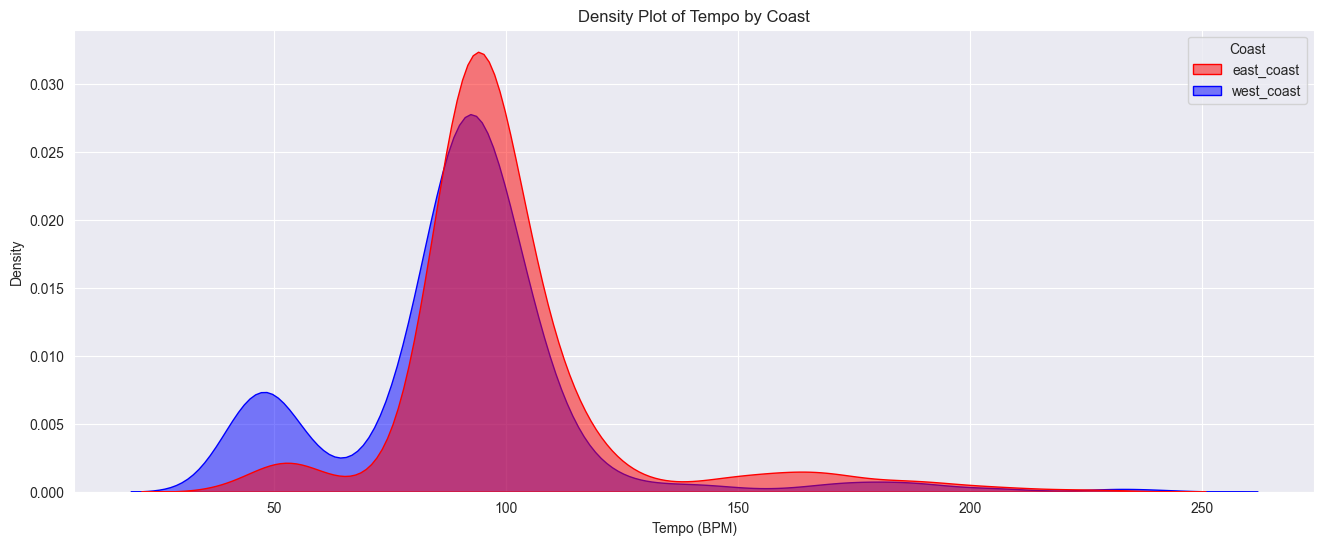

In [58]:
# Set up the figure
plt.figure(figsize=(16, 6))

# Create density plot with 'Tempo1' for each 'Coast', setting custom colors
sns.kdeplot(data=df, x='Tempo1', hue='Coast', fill=True, palette=['red', 'blue'], common_norm=False, alpha=0.5)

# Adding plot title and labels
plt.title('Density Plot of Tempo by Coast')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Density')

# Show the plot
plt.show()

<b>Compare tempo with mean energy of the different artsits</b>

In [65]:
# Assuming df is already defined and loaded with data
only_tempo = df[['Artist', 'Coast', 'Tempo1', 'Tempo2', 'Release Year']].copy()
only_tempo.rename(columns={'Release Year': 'Release_Year'}, inplace=True)  # Renaming for consistency

years = sorted(only_tempo['Release_Year'].unique())
start_year_widget = widgets.IntSlider(min=min(years), max=max(years), value=min(years), description='Start Year:')
end_year_widget = widgets.IntSlider(min=min(years), max=max(years), value=max(years), description='End Year:')

ui = widgets.HBox([start_year_widget, end_year_widget])

def update_range(*args):
    end_year_widget.min = start_year_widget.value  # Ensure end year is always >= start year

start_year_widget.observe(update_range, 'value')

def plot_filtered_data_by_year_range(start_year, end_year):
    try:
        # Filter the DataFrame for songs released within the selected year range
        filtered_df = only_tempo[(only_tempo['Release_Year'] >= start_year) & (only_tempo['Release_Year'] <= end_year)]

        # Group by 'Artist' and 'Coast', calculate the mean for 'Tempo1'
        artist_means = filtered_df.groupby(['Artist', 'Coast']).agg({'Tempo1': 'mean'}).reset_index()

        # Sort the DataFrame by 'Tempo1' in descending order
        artist_means = artist_means.sort_values(by='Tempo1', ascending=False)

        # Create a scatter plot using Plotly Express
        fig = px.scatter(artist_means, x='Artist', y='Tempo1', color='Coast',
                         hover_name='Artist', labels={"Tempo1": "Mean Tempo (BPM)"},
                         category_orders={"Artist": sorted(filtered_df['Artist'].unique())})

        fig.update_layout(title=f'Mean Tempo by Artist (Years {start_year} to {end_year})',
                          xaxis_title='Artist',
                          yaxis_title='Mean Tempo (BPM)',
                          legend_title='Coast')
        fig.show()
    except Exception as e:
        print(f"Error: {e}")

interact(plot_filtered_data_by_year_range, start_year=start_year_widget, end_year=end_year_widget)

interactive(children=(IntSlider(value=1986, description='Start Year:', max=1998, min=1986), IntSlider(value=19…

<function __main__.plot_filtered_data_by_year_range(start_year, end_year)>

<b>This is just the regular, not interactive plot</b>

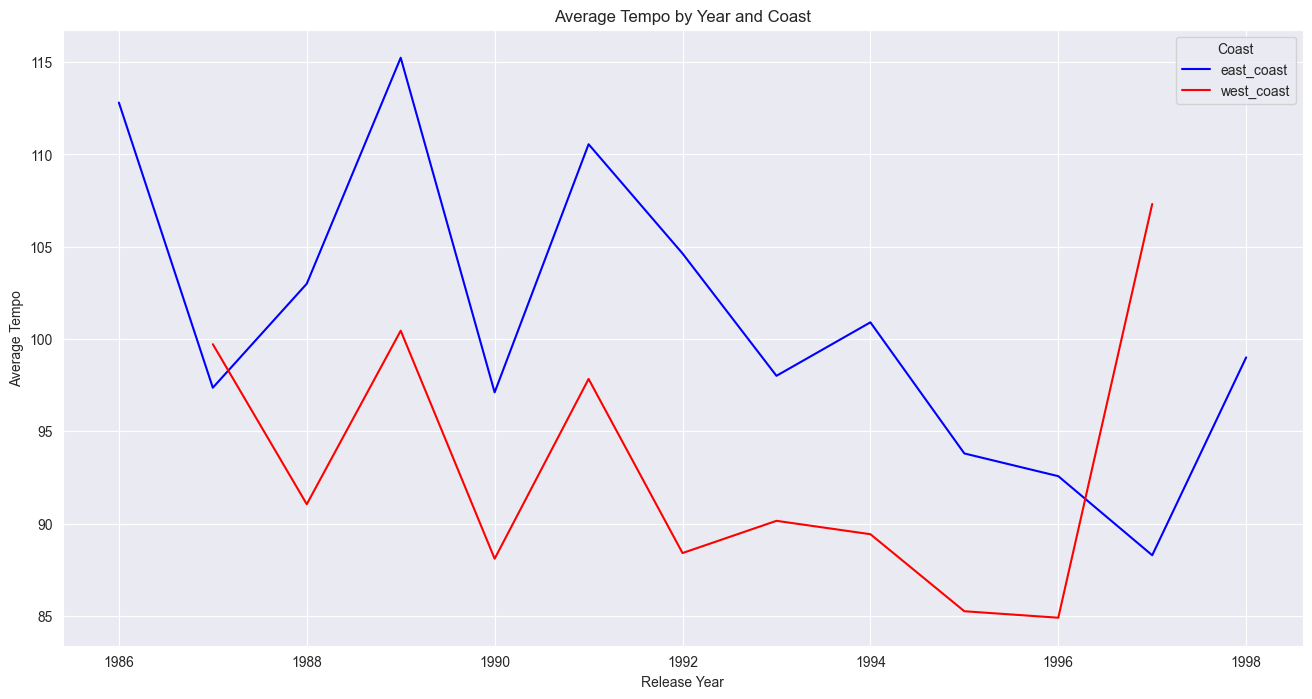

In [69]:
# Calculate the mean tempo for each Coast and Release Year
average_tempo = df.groupby(['Coast', 'Release Year'])['Tempo1'].mean().reset_index()

colors = {
    'east_coast': 'blue',
    'west_coast': 'red',
}

# Set up the figure with a larger size
plt.figure(figsize=(16, 8))  # Width, height in inches

# Plot each coast's average tempo over the years
for coast, color in colors.items():
    # Select the subset of the data for the current coast
    subset = average_tempo[average_tempo['Coast'] == coast]

    # Ensure the data is sorted by year (important if the data isn't sorted in the dataframe)
    subset = subset.sort_values('Release Year')

    # Plotting
    plt.plot(subset['Release Year'], subset['Tempo1'], label=coast, color=color)

# Add legend, labels, and title
plt.legend(title='Coast')
plt.xlabel('Release Year')
plt.ylabel('Average Tempo')
plt.title('Average Tempo by Year and Coast')
plt.grid(True)  # Optionally add a grid for easier visualization

# Show the plot
plt.show()

<b>Let's check the different topics</b>

In [70]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
df_topics = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/baseline_data_w_topics.xlsx', engine='openpyxl')

In [72]:
df_topics

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Topic Model
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah my crew be in the house terra herb mcgruf...,0
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,it be the number one crew in the area big l be...,0
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,there be too many mc 's who be overrate yeah a...,1
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let I get to the point real quick when yeah po...,1
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,a yeah spark up the phillie and pass the stout...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1359,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,I be a say this and I be a end mine if yeah be...,0
1360,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,bitch be not shit but hoe and trick bitch be n...,0
1361,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yes it be I say I and all who agree be more th...,0
1362,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,one two three and to the four snoop doggy dogg...,0


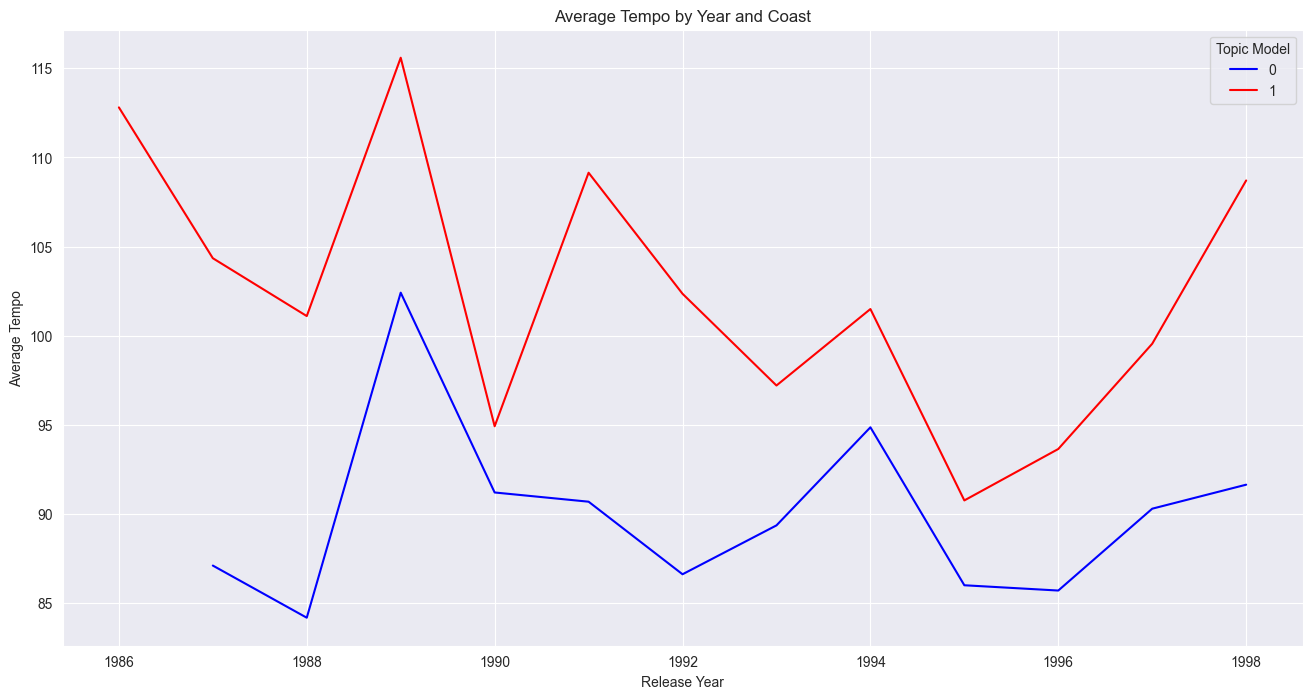

In [76]:
# Calculate the mean tempo for each Coast and Release Year
average_tempo = df_topics.groupby(['Topic Model', 'Release Year'])['Tempo1'].mean().reset_index()

colors = {
    0: 'blue',
    1: 'red',
}

# Set up the figure with a larger size
plt.figure(figsize=(16, 8))  # Width, height in inches

# Plot each coast's average tempo over the years
for topic, color in colors.items():
    # Select the subset of the data for the current coast
    subset = average_tempo[average_tempo['Topic Model'] == topic]

    # Ensure the data is sorted by year (important if the data isn't sorted in the dataframe)
    subset = subset.sort_values('Release Year')

    # Plotting
    plt.plot(subset['Release Year'], subset['Tempo1'], label=topic, color=color)

# Add legend, labels, and title
plt.legend(title='Topic Model')
plt.xlabel('Release Year')
plt.ylabel('Average Tempo')
plt.title('Average Tempo by Year and Topic')
plt.grid(True)  # Optionally add a grid for easier visualization

# Show the plot
plt.show()